### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import MinMaxScaler

sns.set_style("whitegrid")
sns.set_palette("pastel")

### Read dataframe

In [2]:
df = pd.read_csv('data/df_emigrant_population.csv')
df.head(5)

,YEARS,COUNTIES,EMIGRANTS,BORN_URBAN,BORN_RURAL,DEAD_URBAN,DEAD_RURAL,DIVORCES_URBAN,DIVORCES_RURAL,UNEMPLOYMENT_RATE_MALE,UNEMPLOYMENT_RATE_FEMALE,EDUCATIONAL_UNITS,TEACHING_STAFF,CONFLICTS_OF_INTEREST,HOSPITALS
0,Anul 1992,Alba,625.00,2593.00,2211.00,23.00,20.00,388.00,132.00,4.00,7.30,782,5674.00,2.00,10.00
1,Anul 1993,Alba,545.00,2318.00,2125.00,16.00,18.00,343.00,125.00,6.60,9.70,803,5652.00,0.00,10.00
2,Anul 1994,Alba,272.00,2381.00,2028.00,18.00,12.00,570.00,183.00,6.80,9.40,775,5853.00,1.00,9.00
3,Anul 1995,Alba,466.00,2138.00,1936.00,17.00,11.00,448.00,150.00,4.80,9.20,774,5831.00,0.00,9.00
4,Anul 1996,Alba,330.00,2183.00,1876.00,19.00,18.00,458.00,161.00,3.20,6.00,780,6065.00,0.00,10.00


### Check multicolinearity

The covariance matrix of the data is computed and displayed using a heatmap. Covariance is a measure of how changes in one variable are associated with changes in another. The goal here is to visualize the covariance to potentially reveal any multicollinearity (when two or more predictor variables in a multiple regression model are highly correlated).

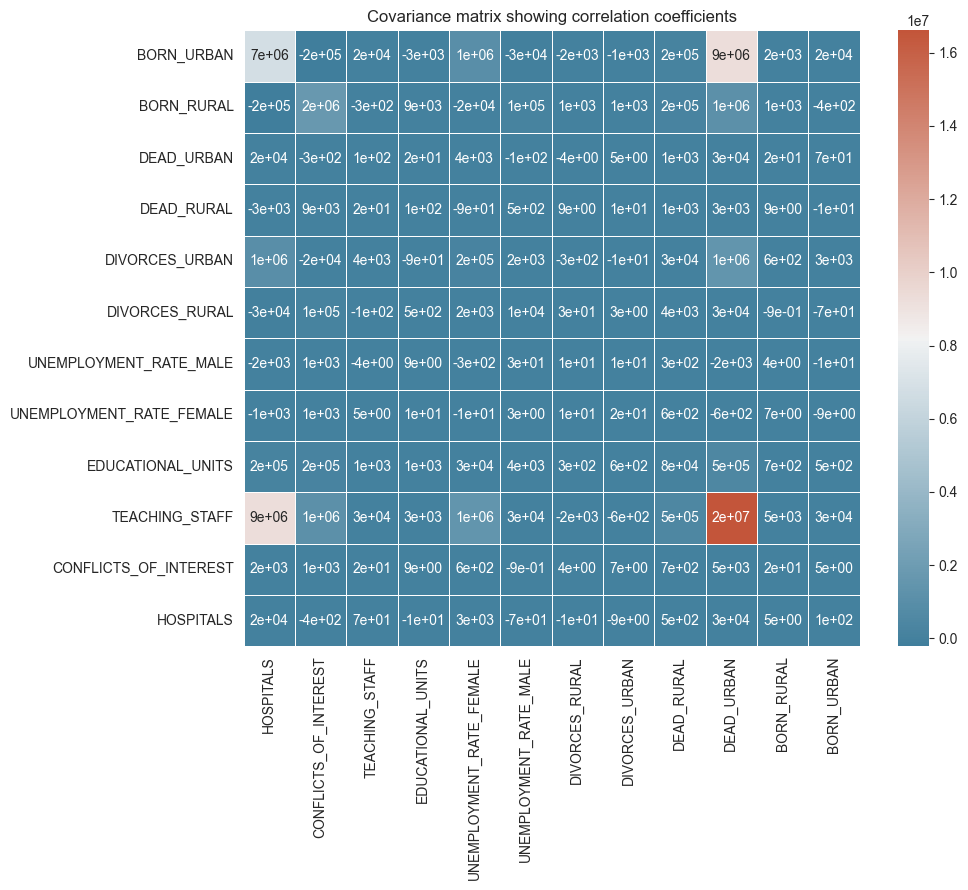

In [3]:
# Calculate the covariance matrix
covariance_matrix = df.iloc[:, 3:].cov()
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create a heatmap
plt.figure(figsize=(10, 8))  # Specify the size of the figure
heatmap = sns.heatmap(covariance_matrix, cmap=cmap, annot=True, fmt=".0e", square=True, linewidths=.5)  # Create a heatmap

# Reverse the order of x-axis labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
heatmap.set_xticklabels(heatmap.get_xticklabels()[::-1])

# Provide a title
plt.title('Covariance matrix showing correlation coefficients')

# Show the plot
plt.show()

### Check correlation matrix

Similar to the covariance matrix, a correlation matrix is also computed and visualized. A correlation matrix gives the correlation coefficients between sets of variables. Correlation coefficients measure the statistical relationship between two variables and ranges from -1 to 1.

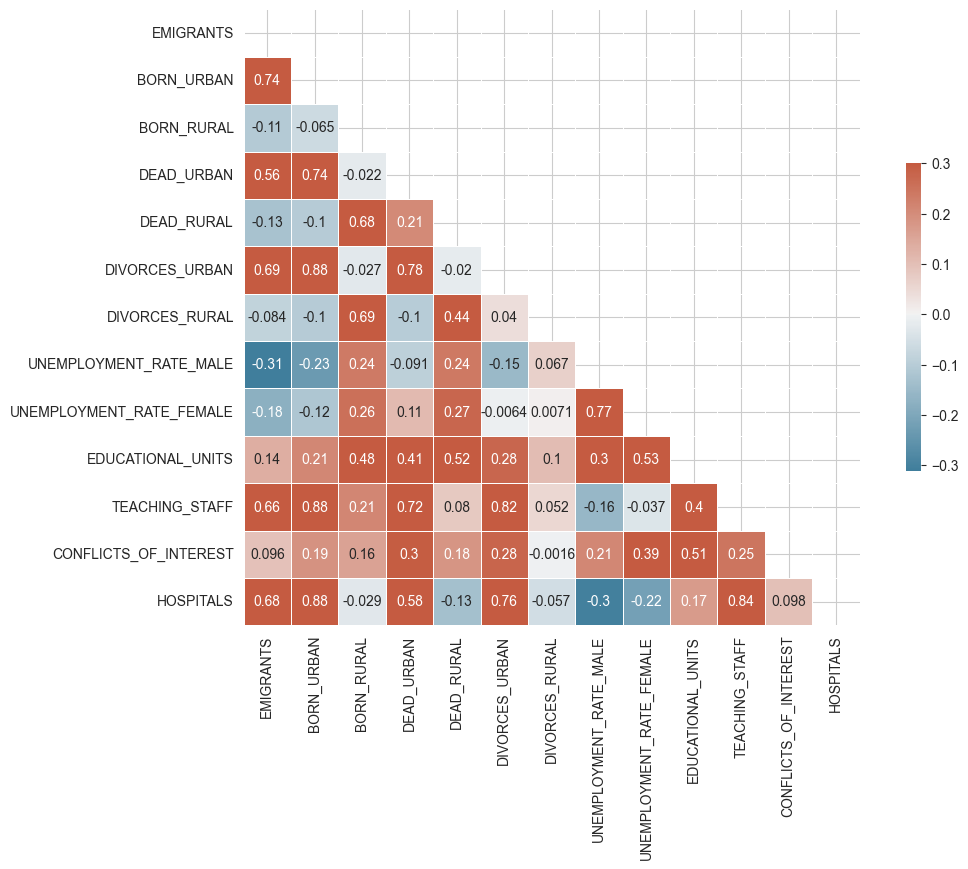

In [4]:
correlation_matrix = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Address multidimensionality

In this section, the Variance Inflation Factor (VIF) is calculated for all variables in the dataset. VIF is a measure of the amount of multicollinearity in a set of multiple regression variables. Variables with a VIF greater than 10 are dropped from the data, as they may be considered highly collinear

In [5]:
X = df.iloc[:, 3:]

# DataFrame to store removed variables and their VIF
removed_variables = pd.DataFrame(columns=["variables", "VIF"])

# Define a flag variable
high_vif = True

while high_vif:
    # Calculate VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # If the maximum VIF is greater than 5, remove a variable with the highest VIF
    if vif["VIF"].max() > 10:
        # Identify the variable with the highest VIF
        removed_variable = vif.loc[vif["VIF"].idxmax()]

        # Store the removed variable
        removed_variables = pd.concat([removed_variables, pd.DataFrame([removed_variable])], ignore_index=True)

        # Drop the variable with the highest VIF from X
        X = X.drop(columns = [removed_variable["variables"]])
    else:
        high_vif = False

In [6]:
removed_variables

,variables,VIF
0,TEACHING_STAFF,29.96
1,BORN_URBAN,21.96
2,BORN_RURAL,18.88
3,UNEMPLOYMENT_RATE_FEMALE,14.39
4,DIVORCES_URBAN,11.53


In [7]:
vif

,variables,VIF
0,DEAD_URBAN,4.34
1,DEAD_RURAL,5.90
2,DIVORCES_RURAL,4.82
3,UNEMPLOYMENT_RATE_MALE,3.71
4,EDUCATIONAL_UNITS,6.01
5,CONFLICTS_OF_INTEREST,1.90
6,HOSPITALS,3.67


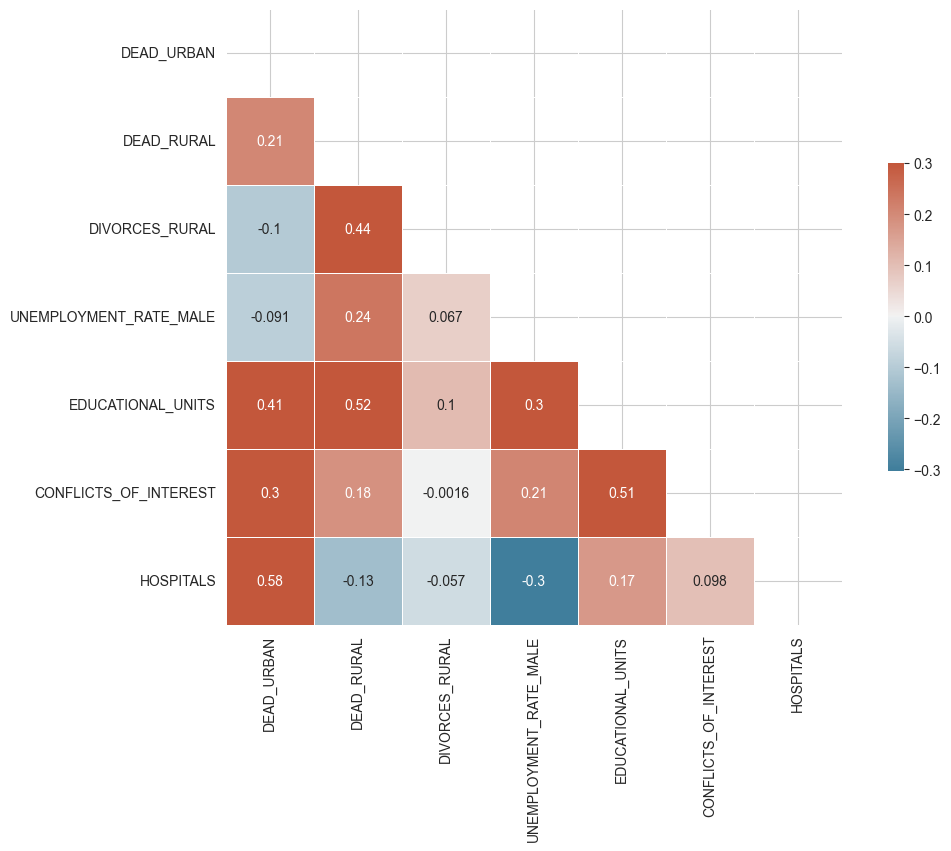

In [8]:
correlation_matrix = X.corr(numeric_only=True)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

### Train-test split

In [9]:
# assuming your feature data is stored in X
y = df['EMIGRANTS']

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

### Data normalization

The feature data (X) is normalized using MinMaxScaler(). This process scales and translates each feature individually such that it falls in the range between 0 and 1.

In [10]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

In [11]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:19<00:00,  2.16it/s]


In [12]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KNeighborsRegressor,0.70,0.71,398.47,0.02
ExtraTreesRegressor,0.64,0.65,436.50,0.33
HistGradientBoostingRegressor,0.62,0.63,446.80,0.41
LGBMRegressor,0.62,0.62,451.11,0.06
OrthogonalMatchingPursuit,0.58,0.58,474.81,0.01
ExtraTreeRegressor,0.57,0.58,479.18,0.01
SGDRegressor,0.56,0.57,484.84,0.01
OrthogonalMatchingPursuitCV,0.55,0.56,488.18,0.01
LassoLarsIC,0.55,0.56,490.00,0.01
